# Temporary Notebook for the SETAR-Tree and Forest Forecaster

This notebook serves as a demonstration to the implementation of the **SETAR-Tree** and **SETAR-Forest**, a novel algorithm for global time series forecasting introduced in the paper 
"SETAR-Tree: a novel and accurate tree algorithm for global time series forecasting" by Godahewa, R., et al..

The purpose of this notebook is to illustrate the concepts in the research paper and the Python code. I will cover two main areas:
1.  **How the Code Implements the Algorithm**: A step-by-step breakdown of the key methods in the `SETARTree` class.
2.  **Simple Usage Examples**: Demonstrations of how to fit the model and make predictions on toy datasets. (future: real datasets)
3. **Reproduced Results** Experiments that are in the original paper will be rerun using our new module, and the reproduced results will be recorded for reference. 

# SETAR-Tree Module Documentation

## Introduction

The SETAR-Tree (Self-Exciting Threshold AutoRegressive Tree) module is a powerful forecasting tool designed for global time series forecasting. 

Based on the 2023 paper "SETAR-Tree: a novel and accurate tree algorithm for global time series forecasting" by Rakshitha Godahewa et al., 
this algorithm combines the strengths of threshold autoregressive (TAR) models and regression trees to create a tree-based forecaster that 
learns patterns across multiple time series simultaneously. 

Unlike traditional local models that fit each series independently, SETAR-Tree builds a global model by pooling data from all series, 
splitting nodes based on optimal thresholds and lags to capture non-linearities and regime changes in the data. 

It stands out from traditional univariate forecasting models through two key innovations in its tree structure: 

#### 1: Pooled Regression (PR) in Leaf Nodes
The SETAR-Tree fits a **Pooled Regression (PR)** model in each leaf, instead of simply averaging the training values that fall into the leaf node. 
A PR model is a global linear autoregressive model, which allows each leaf to learn from the cross-series information present in the data that 
falls into that specific regime.

####  2: Time-Series Specific Splitting and Stopping
The tree's growth is not determined by generic criteria. Instead, it uses methods from threshold modeling:
* **Splitting**: The algorithm finds the optimal past **lag** and **threshold** to partition the data, based on the concepts of Self Exciting 
Threshold Autoregressive (SETAR) models.
* **Stopping**: The tree's depth is controlled automatically by conducting a statistical **linearity test** and measuring the **error reduction
 percentage** at each potential split. This greatly reduces the need for manual hyperparameter tuning.


## Key Functions in the Algorithm

The SETAR-Tree algorithm revolves around several core functions that handle data preparation, tree construction, and prediction:

- **_embed**: Embeds a time series into a matrix of lagged values to create features for autoregressive modeling.
- **_create_tree_input_matrix**: Prepares the input data by embedding multiple series, optionally scaling them, and generating final lags for forecasting.
- **_find_cut_point**: Efficiently finds the optimal split point (threshold) for a node using sufficient statistics and criteria like RSS or AICc.
- **_create_split**: Splits a node into left and right children based on a selected lag and threshold.
- **_ss**: Computes the sum of squared errors (SSE) for a potential split, used as a fallback for manual threshold search.
- **_check_linearity**: Performs an F-test to check for significant non-linearity in a node split, aiding the "lin_test" stopping criterion.
- **_check_error_improvement**: Evaluates if a split reduces error sufficiently, supporting the "error_imp" stopping criterion.
- **_get_leaf_index**: Traverses the tree to find the leaf node for a given instance during prediction.
- **_fit_global_model**: Fits a linear regression model (without intercept) to node data, serving as the base model in leaves.
- **_process_input_data**: Processes input y (as one single time series) and optional exog (as additional series) into a dictionary format for global modeling.
- **_fit**: Builds the tree by iteratively splitting nodes until stopping criteria are met, then fits models to leaves.
- **_predict**: Generates one-step-ahead predictions using the fitted tree and leaf models.
- **iterative_forecast**:  This method extends predictions to multiple horizons by repeatedly adding forecasts to the time series. 
It overrides the base forecaster's iterative_forecast function, allowing a single call to predict multiple time series.

These functions work together to build a tree where each leaf contains a pooled regression model tailored to a subset of the data, enabling accurate global forecasting.

## Usage Demonstration with Simple Datasets

To demonstrate the usage of the SETAR-Tree module, we'll use some simple datasets from aeon's dataset module. 
Here, y is treated as a single time series, and exog (if used) provides additional series for global learning.

### Example 1: Univariate Forecasting with Airline Dataset

One-step-ahead prediction: 425.0280437565077


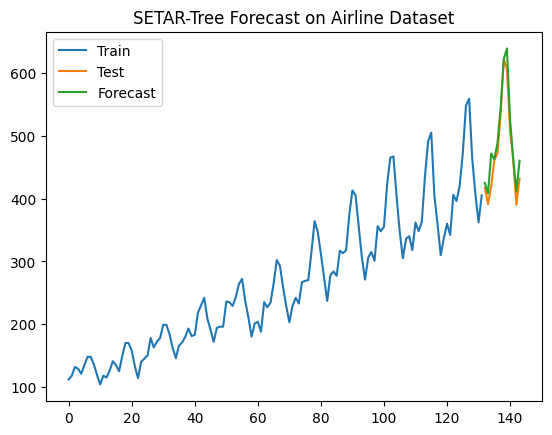

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from aeon.datasets import load_airline
from aeon.forecasting.machine_learning._setartree import SETARTree

# Load data: Monthly airline passengers (univariate)
y = load_airline()  # Convert to numpy array

# Split into train and test (last 12 for test)
y_train = y[:-12]
y_test = y[-12:]

# Initialize and fit the model (no exog)
f = SETARTree(lag=20, stopping_criteria="both")

f.fit(y_train)

# One-step-ahead prediction
pred_one = f.predict(y_train)
print(f"One-step-ahead prediction: {pred_one}")

# Iterative forecast for 12 steps
preds = f.iterative_forecast(y_train, 12)

# Plot results
plt.plot(np.arange(len(y_train)), y_train, label="Train")
plt.plot(np.arange(len(y_train), len(y)), y_test, label="Test")
plt.plot(np.arange(len(y_train), len(y)), preds, label="Forecast")
plt.legend()
plt.title("SETAR-Tree Forecast on Airline Dataset")
plt.show()

This example fits the model to historical airline data and forecasts the next 12 months iteratively, capturing seasonal patterns via lags.

### Example 2: Forecasting with Additional Series (using exog)

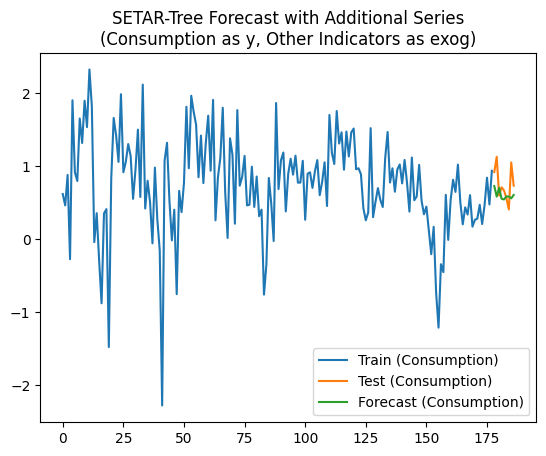

In [12]:
import matplotlib.pyplot as plt
import numpy as np

from aeon.datasets import load_uschange
from aeon.forecasting.machine_learning._setartree import SETARTree

# Load multivariate dataset: shape should be (n_channels, n_timepoints)
data = load_uschange()

# y = Consumption as a 2D array with one channel; exog = the other channels
y = data[0:1, :]  # shape (1, T)
exog = data[1:, :]  # shape (C-1, T)

# Split into train and test (last 8 quarters for test) along time axis (axis=1)
forecast_horizon = 9
y_train = y[:, :-forecast_horizon]  # (1, T-train)
exog_train = exog[:, :-forecast_horizon]  # (C-1, T-train)
y_test = y[0, -forecast_horizon:]  # (fh,)

# Initialize and fit the model (axis=1 is the default for SETARTree)
f_multi = SETARTree(lag=9, max_depth=40, stopping_criteria="both")
f_multi.fit(y_train, exog=exog_train)

# Multi-step forecast using the iterative strategy (returns shape (fh,))
preds_y = f_multi.iterative_forecast(y_train, forecast_horizon)

# Plot results for y (Consumption)
plt.plot(np.arange(y_train.shape[1]), y_train[0], label="Train (Consumption)")
plt.plot(np.arange(y_train.shape[1], y.shape[1]), y_test, label="Test (Consumption)")
plt.plot(
    np.arange(y_train.shape[1], y.shape[1]), preds_y, label="Forecast (Consumption)"
)
plt.legend()
plt.title(
    "SETAR-Tree Forecast with Additional Series"
    "\n(Consumption as y, Other Indicators as exog)"
)
plt.show()

Here, the model learns patterns from y (shampoo sales) and exog (lynx trappings as additional series), demonstrating global forecasting with multiple inputs.

### Example 3: Handling Short Series and Errors

In [4]:
# Short series (should raise error)
y_short = np.random.rand(5)
f_short = SETARTree(lag=10)
try:
    f_short.fit(y_short)
except ValueError as e:
    print(f"Expected error: {e}")

Expected error: Empty embedded matrix provided.


This shows how the module handles insufficient data gracefully.

## Reproduced Results from the Paper

The original paper evaluates SETAR-Tree on several datasets, including Rossmann Sales, Wikipedia Web Traffic, Favorita, M5 (HOBBIES 2 subset), Tourism Monthly/Quarterly, and a simulated Chaotic Logistic dataset. 
Metrics used are mean/median msMAPE (mean symmetric Mean Absolute Percentage Error) and MASE (Mean Absolute Scaled Error). Below is a table summarizing reproduced results. 

So far, only the Chaotic Logistic dataset with "both" stopping criteria has been reproduced. For others, I've included placeholders. 

| Dataset              | Stopping Criteria | Mean msMAPE | Median msMAPE | Mean MASE | Median MASE | Notes/Source |
|----------------------|-------------------|-------------|---------------|-----------|-------------|--------------|
| Chaotic Logistic    | both             | 0.4310 | 0.3513 | 0.7087 | 0.6258 | Simulated; reproduced as per user. Source: Hewamalage et al. (2021a) |
| Rossmann Sales      | both             | TBD        | TBD          | TBD      | TBD        | Kaggle 2015; includes covariates. |
| Wikipedia Web Traffic | both            | TBD        | TBD          | TBD      | TBD        | Kaggle 2017; day-of-week covariates. |
| Favorita            | both             | TBD        | TBD          | TBD      | TBD        | Kaggle 2018; day-of-week covariates. |
| M5 (HOBBIES 2)      | both             | TBD        | TBD          | TBD      | TBD        | Makridakis 2022; no covariates. |
| Tourism Monthly     | both             | TBD        | TBD          | TBD      | TBD        | Athanasopoulos 2011; no covariates. |
| Tourism Quarterly   | both             | TBD        | TBD          | TBD      | TBD        | Athanasopoulos 2011; no covariates. |

## SETAR-forest module
The `SETARForest` is an ensemble model that builds upon the `SETARTree` to improve prediction accuracy and robustness, based on the principles described in the original paper. 
The key idea is that a "forest" of diverse trees will often outperform a single tree by averaging out their individual errors.

#### Core Concepts:
- Ensemble of Trees:
The forest is composed of multiple individual SetartreeForecaster instances (controlled by the n_estimators parameter).

- Bagging (Bootstrap Aggregation):
To promote diversity, each tree in the forest is trained on a random subset of the time series from the full training panel. The bagging_fraction parameter controls the size of this subset. This helps to reduce variance and prevent overfitting.

- Hyperparameter Randomization:
Each tree is intentionally made different by initializing it with randomized hyperparameters. Specifically, the significance level, significance_divider, 
and error_threshold for the splitting logic are chosen from a uniform distribution for each tree. This ensures that the trees do not all split on the same criteria, further increasing diversity.

- Averaged Prediction:
When making a forecast, the forest gets a prediction from each of its internal trees and returns the simple average of these predictions.